# **Simulación sistema Controlador-Motor**

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## **Definiciones y condiciones iniciales**

### Definimos el tiempo de simulación

In [2]:
t_simulation=5   # Define here the simulation time
Step_size=0.001     # Define here the time step
dt=h=Step_size      # Asing identifiers to the time step
t_sim=np.arange(0, t_simulation, dt)    #Create a vector simulation time

###  Definimos condiciones iniciales para el vector solución del sistema

In [3]:
#Initial conditions for the system equations
In_current= 0          # Define Initial current 
In_position= 0         # Define Initial angular position 
In_velocity= 0         # Define Initial angular velocity
x0=np.array([ In_current, In_position, In_velocity ])  

### Definimos entradas externas 

In [4]:
#External torque
Tl=np.zeros_like(t_sim)

### Creamos el vector solución y le asignamos las condiciones iniciales.

In [5]:
x_sol=np.zeros((len(t_sim), len(x0)))
x_sol[0]=x0

### Definimos una función para el modelo del sistema

In [6]:
# Define the model equations or system dynamics
def model_motor(x, u, Tl):
                       # u -> control input (voltaje)
                       #Tl -> external torque (Definir unidades ?)
    R=0.343            # Impedance
    L = 0.00018        # Inductance
    kb=0.0167          # contraelectromotriz constant
    Jm=2.42*10**-6     # Motor inertia
    kt=0.0167          # Torque constant
    B=5.589458*10**-6

    current=x[0]       # Current
    theta=x[1]         # Angular postion
    theta_dot=x[2]     # Angular velocity

    current_dot=(1/L)*u -(R/L)*current -(kb/L)*theta_dot       # Derivative of current
    theta_ddot= (kt/Jm)*current -(B/Jm)*theta_dot - (1/Jm)*Tl  # Angular aceleration
    return np.array([ current_dot, theta_dot, theta_ddot])  # return [derivative of current, angular velocity, angular acceleration]


### Definimos la referencia

In [7]:
Corriente_referencia=0.2
I_reference= Corriente_referencia*np.ones(len(t_sim))
#print(I_reference)

# Definimos ganancias del controlador PI

In [8]:
#Define the gain values
Kp=0.0
Ki=103.632275098676

### Definimos la condición inicial para la integral del error del controlador PI

In [9]:
E_integral_initial=0     #Integral initial condition

### Creamos el vector solución de la integral y le asignamos la condición inicial

In [10]:
#E_integral=np.zeros((len(t_sim),1)) # Create the solution vector for the erro integral

#E_integral[0]= E_integral_initial  # Assign the initial condition to the solution vector of the integral.
E_integral= E_integral_initial  # Assign the initial condition to the solution vector of the integral.

### Creamos una función para el controlador

In [11]:
def PI_control(Kp,Ki,error,E_integral):
    Pout=Kp*error
    Iout=Ki*E_integral
    Salida_PI= Pout+Iout
    return Salida_PI

### Creamos una función para el solver Runge Kutta Dormand Prince

In [12]:
# #inputs RKDP_solver(h, x_sol[i-1], u[i-1], TL[i-1])
def RKDP_solver(h, x, u, Tl):
    k1=h*model_motor(x, u, Tl)
    k2=h*model_motor(x + (k1/5), u ,Tl )
    k3=h*model_motor(x + (3/40)*k1 + (9/40)*k2, u ,Tl )
    k4=h*model_motor(x + (44/45)*k1 - (56/15)*k2 + (32/9)*k3, u ,Tl )
    k5=h*model_motor(x + (19372/6561)*k1 - (25360/2187)*k2 +(64448/6561)*k3 - (212/729)*k4, u ,Tl )
    k6=h*model_motor(x + (9017/3168)*k1 -(355/33)*k2 +(46732/5247)*k3 + (49/176)*k4 - (5103/18656)*k5, u ,Tl )
    k7=h*model_motor(x + (35/384)*k1 +(500/1113)*k3 +(125/192)*k4 -(2187/6784)*k5 + (11/84)*k6, u ,Tl )
    return k1, k2, k3,  k4, k5, k6, k7
    
# Assign letter to fractional quantity
a=35/384
b=500/1113
c=125/192
d=2187/6784
e=11/84

## **Bucle principal**

In [13]:
### Create  for loop for iterating over the simulation time
for i in range(1, len(t_sim)):
    #I_error= I_reference      -   I_calculated 
    I_error=  I_reference[i-1] - x_sol[i-1,0]                      # Error 
    E_integral=E_integral+ (I_error*dt)
 
    u=PI_control(Kp,Ki,I_error, E_integral)                        # Control signal
    
    k1, k2, k3,k4,k5,k6,k7= RKDP_solver(h, x_sol[i-1], u, Tl[i-1]) # Get the RK DP termns using the RKDP_solver function
    
    x_sol[i]=x_sol[i-1]+ a*k1 + b*k3 + c*k4 - d*k5 + e*k6          # Calculating the values for the vector solution a this time step.


## Graficamos la respuesta obtenida para  la señal que es objeto de control, en este caso corriente.

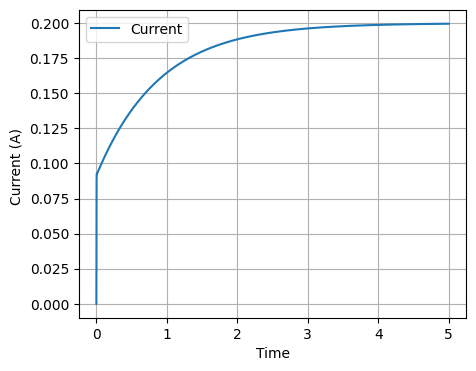

In [14]:
plt.figure(figsize=(5,4))
plt.plot(t_sim, x_sol[:, 0], label='Current')  # Plot current
#plt.plot(t_sim2, x_sim2[:, 1], label='Theta')  # Plot angular position
#plt.plot(t_sim2, x_sim2[:, 2], label='Theta_dot')  # Plot angular velocity
plt.xlabel('Time')
#plt.ylabel('Current/ Angle / Angular velocity')
plt.ylabel('Current (A) ')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
## Saving the data in a csv file.
df=pd.DataFrame()
tiempo=t_sim
corriente= x_sol[:,0]
velocidad= x_sol[:, 2]
## columns name
df['Tiempo']=tiempo
df['Corriente']= corriente
df['Velocidad']= velocidad
print(df)

df.to_csv('DATO_python_150823.csv', sep=',', header=True, index=False)


      Tiempo  Corriente   Velocidad
0      0.000   0.000000    0.000000
1      0.001   0.045832    0.222885
2      0.002   0.075783    0.702756
3      0.003   0.088412    1.315980
4      0.004   0.092157    1.976746
...      ...        ...         ...
4995   4.995   0.199600  595.345815
4996   4.996   0.199600  595.348289
4997   4.997   0.199600  595.350761
4998   4.998   0.199601  595.353230
4999   4.999   0.199601  595.355696

[5000 rows x 3 columns]



# Graficar imagenes en subplot
# Programar visualización grafica en tiempo real
# Probar calculo de controlador a partir de la optimización
# Probar loop de control en velocidad

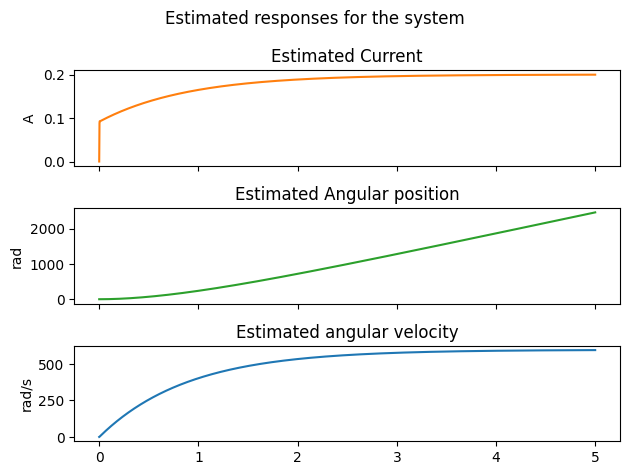

In [33]:
# Plot the 3 variables in subplots
fig, (a1, a2, a3) = plt.subplots(3,sharex=True)
fig.suptitle('Estimated responses for the system')
a1.plot(t_sim, x_sol[:, 0],'tab:orange')
a1.set_title("Estimated Current")
a1.set_ylabel('A')
a2.plot(t_sim, x_sol[:, 1], 'tab:green')
a2.set_title("Estimated Angular position")
a2.set_ylabel('rad')
a3.plot(t_sim, x_sol[:, 2], 'tab:blue')
a3.set_title("Estimated angular velocity")
a3.set_ylabel('rad/s')

fig.tight_layout()

# Se aplicaron valores sintonizados en Simulink para el controlador Pi, kp=0 y Ki= 103.632275098676, dando el mismo resultado en los plot de ambos programas.


In [21]:
numero=
if(numero % 100 == 0):
    print(numero)